 # Análisis de Emocionalidad Gramatical en Letras Musicales
 Este notebook determina la correlación entre estructura morfosintáctica y temática emocional

## Sección 1: Importar librerías y cargar datos

In [3]:
# 1. Importar librerías y cargar datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from src.utils import path
from scipy import stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency, f_oneway
import spacy
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Cargar modelo de spaCy
nlp = spacy.load("en_core_web_sm")

print("✓ Librerías importadas correctamente")
print(f"✓ Modelo spaCy cargado: {nlp.meta['name']}")

✓ Librerías importadas correctamente
✓ Modelo spaCy cargado: core_web_sm


In [4]:
# Cargar datos procesados# Cargar datos procesados
directorio_proyecto = path.obtener_ruta_local()
df = pd.read_csv(
    directorio_proyecto + '\\data\\results\\corpus_canciones_spacy.csv',
    delimiter=',',
    decimal=".",
    encoding='utf-8'
)

print(f"Dataset cargado: {df.shape[0]} canciones")
print(f"Géneros disponibles: {df['Genero'].unique()}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())
directorio_proyecto = path.obtener_ruta_local()
df = pd.read_csv(
    directorio_proyecto + '\\data\\results\\corpus_canciones_spacy.csv',
    delimiter=',',
    decimal=".",
    encoding='utf-8'
)

print(f"Dataset cargado: {df.shape[0]} canciones")
print(f"Géneros disponibles: {df['Genero'].unique()}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())

Dataset cargado: 5208 canciones
Géneros disponibles: ['pop' 'alternative pop' 'K-pop' 'hip hop' 'alternative rock' 'dance-pop'
 'r&b']

Columnas disponibles:
['Artist', 'nombre_cancion', 'letra_cancion', 'Periodo', 'Genero', 'tokens', 'Etiquetado_POS', 'StopWords', 'Minusculas', 'Lematizado']
Dataset cargado: 5208 canciones
Géneros disponibles: ['pop' 'alternative pop' 'K-pop' 'hip hop' 'alternative rock' 'dance-pop'
 'r&b']

Columnas disponibles:
['Artist', 'nombre_cancion', 'letra_cancion', 'Periodo', 'Genero', 'tokens', 'Etiquetado_POS', 'StopWords', 'Minusculas', 'Lematizado']


## Sección 2: Funciones auxiliares para análisis emocional

In [5]:
# 2. Funciones auxiliares para análisis emocional

def extraer_pos_tags(pos_string):
    """Extrae las etiquetas POS de una cadena de texto."""
    if pd.isna(pos_string):
        return []
    tags = re.findall(r",\s*'([^']+)'\)", str(pos_string))
    return tags

def calcular_densidad_adjetivos(pos_list):
    """
    Calcula la densidad de adjetivos.
    Adjetivos / total tokens
    """
    if not pos_list or len(pos_list) == 0:
        return 0

    adjetivos = sum(1 for tag in pos_list if tag == 'ADJ')
    total = len(pos_list)

    return (adjetivos / total * 100) if total > 0 else 0

def calcular_ratio_verbos_accion_estado(texto):
    """
    Calcula el ratio entre verbos de acción y verbos de estado.
    Verbos de acción: verbos dinámicos (run, jump, create, etc.)
    Verbos de estado: verbos estáticos (be, seem, feel, etc.)
    """
    if pd.isna(texto):
        return 0

    doc = nlp(str(texto))

    # Verbos de estado comunes en inglés
    verbos_estado = {
        'be', 'am', 'is', 'are', 'was', 'were', 'been', 'being',
        'seem', 'appear', 'look', 'feel', 'sound', 'taste', 'smell',
        'remain', 'stay', 'become', 'exist', 'have', 'own', 'possess',
        'know', 'believe', 'think', 'understand', 'love', 'hate', 'want', 'need'
    }

    verbos_accion = 0
    verbos_estado_count = 0

    for token in doc:
        if token.pos_ in ['VERB', 'AUX']:
            if token.lemma_.lower() in verbos_estado:
                verbos_estado_count += 1
            else:
                verbos_accion += 1

    # Ratio: verbos de acción / verbos de estado
    return verbos_accion / verbos_estado_count if verbos_estado_count > 0 else verbos_accion

def calcular_complejidad_sintactica(pos_list):
    """
    Calcula un índice de complejidad sintáctica.
    Basado en: adjetivos + adverbios + conjunciones subordinantes
    """
    if not pos_list or len(pos_list) == 0:
        return 0

    elementos_complejos = sum(1 for tag in pos_list if tag in ['ADJ', 'ADV', 'SCONJ'])
    total = len(pos_list)

    return (elementos_complejos / total * 100) if total > 0 else 0

def analizar_polaridad_emocional(texto):
    """
    Analiza la polaridad emocional del texto.
    Retorna: polaridad (-1 a 1) y subjetividad (0 a 1)
    """
    if pd.isna(texto):
        return 0, 0

    try:
        blob = TextBlob(str(texto))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0

def categorizar_emocion(polaridad):
    """
    Categoriza la emoción basada en la polaridad.
    """
    if polaridad > 0.3:
        return 'Positiva'
    elif polaridad < -0.3:
        return 'Negativa'
    else:
        return 'Neutral'

def calcular_intensidad_emocional(subjetividad, densidad_adj):
    """
    Calcula un índice de intensidad emocional.
    Combina subjetividad con densidad de adjetivos.
    """
    return (subjetividad * 0.6 + (densidad_adj / 100) * 0.4)

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


## Sección 3: Preprocesar y calcular métricas emocionales

In [6]:
# 3. Preprocesar y calcular métricas emocionales

print("="*80)
print("CALCULANDO MÉTRICAS MORFOSINTÁCTICAS Y EMOCIONALES")
print("="*80)

print("\nExtrayendo características morfosintácticas...")

# Extraer POS tags
df['pos_list'] = df['Lematizado'].apply(extraer_pos_tags)

# Métricas morfosintácticas
df['densidad_adjetivos'] = df['pos_list'].apply(calcular_densidad_adjetivos)
df['ratio_verbos_accion_estado'] = df['letra_cancion'].apply(calcular_ratio_verbos_accion_estado)
df['complejidad_sintactica'] = df['pos_list'].apply(calcular_complejidad_sintactica)

print("✓ Métricas morfosintácticas calculadas")

print("\nAnalizando emocionalidad del texto...")

# Análisis emocional
df[['polaridad', 'subjetividad']] = df['letra_cancion'].apply(
    lambda x: pd.Series(analizar_polaridad_emocional(x))
)

df['categoria_emocional'] = df['polaridad'].apply(categorizar_emocion)
df['intensidad_emocional'] = df.apply(
    lambda row: calcular_intensidad_emocional(row['subjetividad'], row['densidad_adjetivos']),
    axis=1
)

print("✓ Análisis emocional completado")

# Resumen
print("\n" + "="*80)
print("RESUMEN DE MÉTRICAS CALCULADAS")
print("="*80)
print("\nMétricas morfosintácticas:")
print(df[['densidad_adjetivos', 'ratio_verbos_accion_estado', 'complejidad_sintactica']].describe())

print("\nMétricas emocionales:")
print(df[['polaridad', 'subjetividad', 'intensidad_emocional']].describe())

print("\nDistribución de categorías emocionales:")
print(df['categoria_emocional'].value_counts())

CALCULANDO MÉTRICAS MORFOSINTÁCTICAS Y EMOCIONALES

Extrayendo características morfosintácticas...
✓ Métricas morfosintácticas calculadas

Analizando emocionalidad del texto...
✓ Análisis emocional completado

RESUMEN DE MÉTRICAS CALCULADAS

Métricas morfosintácticas:
       densidad_adjetivos  ratio_verbos_accion_estado  complejidad_sintactica
count         5208.000000                 5208.000000             5208.000000
mean             8.931953                    2.923114               11.988953
std              6.213039                    5.072959                7.299144
min              0.000000                    0.000000                0.000000
25%              5.063291                    1.390244                7.500000
50%              8.223513                    2.023810               11.250000
75%             11.656442                    3.000000               15.586161
max            100.000000                  186.000000              100.000000

Métricas emocionales:
      

## Sección 4: Análisis de correlaciones

In [7]:
# 4. Análisis de correlaciones entre morfosintaxis y emoción

print("="*80)
print("ANÁLISIS DE CORRELACIONES")
print("="*80)

# Seleccionar variables para correlación
variables_morfosintacticas = [
    'densidad_adjetivos',
    'ratio_verbos_accion_estado',
    'complejidad_sintactica'
]

variables_emocionales = [
    'polaridad',
    'subjetividad',
    'intensidad_emocional'
]

# Calcular matriz de correlaciones
df_correlacion = df[variables_morfosintacticas + variables_emocionales].dropna()

matriz_correlacion = df_correlacion.corr()

print("\nMatriz de correlación completa:")
print(matriz_correlacion.round(3))

# Extraer correlaciones específicas entre morfosintaxis y emoción
print("\n" + "-"*80)
print("CORRELACIONES ESPECÍFICAS: MORFOSINTAXIS ↔ EMOCIÓN")
print("-"*80)

for var_morfo in variables_morfosintacticas:
    print(f"\n{var_morfo}:")
    for var_emoc in variables_emocionales:
        corr, p_value = pearsonr(
            df_correlacion[var_morfo],
            df_correlacion[var_emoc]
        )
        significancia = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"  → {var_emoc}: r={corr:.4f}, p={p_value:.4f} {significancia}")

print("\nLeyenda: *** p<0.001, ** p<0.01, * p<0.05, ns=no significativo")
print("="*80)

ANÁLISIS DE CORRELACIONES

Matriz de correlación completa:
                            densidad_adjetivos  ratio_verbos_accion_estado  \
densidad_adjetivos                       1.000                      -0.106   
ratio_verbos_accion_estado              -0.106                       1.000   
complejidad_sintactica                   0.867                      -0.121   
polaridad                               -0.020                      -0.025   
subjetividad                             0.209                      -0.034   
intensidad_emocional                     0.425                      -0.056   

                            complejidad_sintactica  polaridad  subjetividad  \
densidad_adjetivos                           0.867     -0.020         0.209   
ratio_verbos_accion_estado                  -0.121     -0.025        -0.034   
complejidad_sintactica                       1.000     -0.004         0.194   
polaridad                                   -0.004      1.000         0.168   

## Sección 5: Visualización de correlaciones

VISUALIZACIÓN DE CORRELACIONES


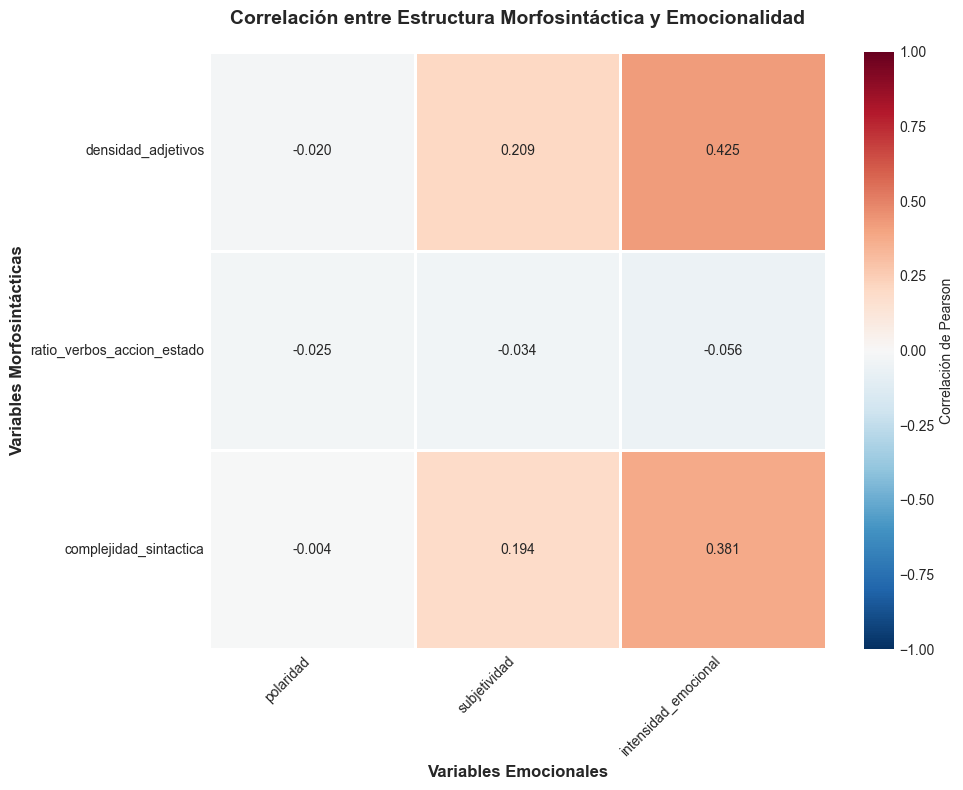

✓ Heatmap de correlaciones creado


In [8]:
# 5. Visualización de correlaciones

print("="*80)
print("VISUALIZACIÓN DE CORRELACIONES")
print("="*80)

# Heatmap de correlaciones
fig, ax = plt.subplots(figsize=(10, 8))

# Seleccionar solo correlaciones entre morfosintaxis y emoción
correlaciones_cruzadas = matriz_correlacion.loc[
    variables_morfosintacticas,
    variables_emocionales
]

sns.heatmap(correlaciones_cruzadas,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlación de Pearson'},
            linewidths=1,
            ax=ax)

ax.set_xlabel('Variables Emocionales', fontsize=12, fontweight='bold')
ax.set_ylabel('Variables Morfosintácticas', fontsize=12, fontweight='bold')
ax.set_title('Correlación entre Estructura Morfosintáctica y Emocionalidad',
             fontsize=14, fontweight='bold', pad=20)

# Rotar etiquetas
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("✓ Heatmap de correlaciones creado")

## Sección 6: Análisis por categoría emocional

ANÁLISIS POR CATEGORÍA EMOCIONAL

Estadísticas por categoría emocional:
                     num_canciones  densidad_adjetivos_mean  \
categoria_emocional                                           
Negativa                        63                   12.226   
Neutral                       4539                    8.906   
Positiva                       606                    8.783   

                     densidad_adjetivos_std  ratio_verbos_accion_estado_mean  \
categoria_emocional                                                            
Negativa                             11.169                            3.111   
Neutral                               6.014                            2.911   
Positiva                              6.854                            2.998   

                     ratio_verbos_accion_estado_std  \
categoria_emocional                                   
Negativa                                      3.298   
Neutral                                       

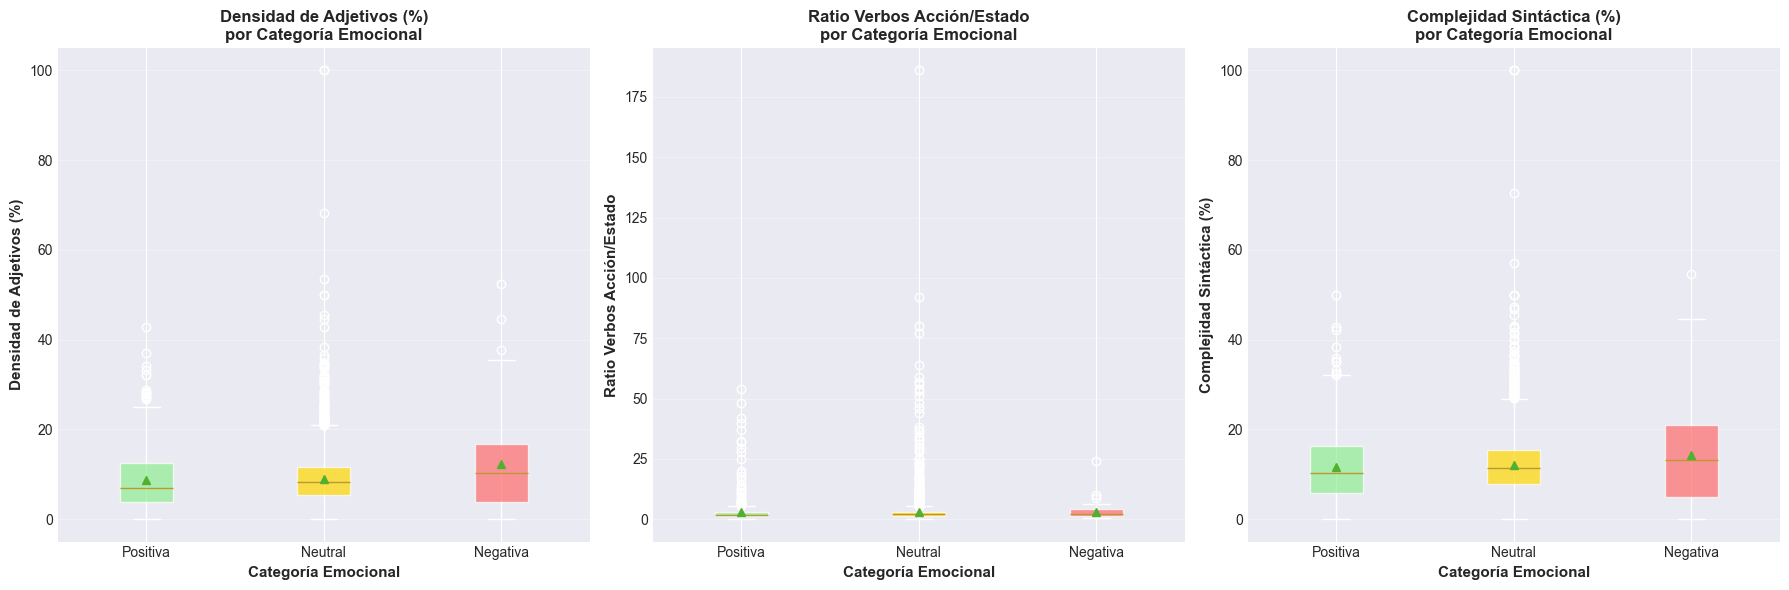

✓ Visualizaciones por categoría emocional creadas


In [9]:
# 6. Análisis por categoría emocional

print("="*80)
print("ANÁLISIS POR CATEGORÍA EMOCIONAL")
print("="*80)

# Estadísticas por categoría emocional
stats_emocionales = df.groupby('categoria_emocional').agg({
    'nombre_cancion': 'count',
    'densidad_adjetivos': ['mean', 'std'],
    'ratio_verbos_accion_estado': ['mean', 'std'],
    'complejidad_sintactica': ['mean', 'std'],
    'intensidad_emocional': ['mean', 'std']
}).round(3)

stats_emocionales.columns = ['_'.join(col).strip() for col in stats_emocionales.columns.values]
stats_emocionales = stats_emocionales.rename(columns={'nombre_cancion_count': 'num_canciones'})

print("\nEstadísticas por categoría emocional:")
print(stats_emocionales)

# Visualización: Comparación de métricas por categoría emocional
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

categorias = ['Positiva', 'Neutral', 'Negativa']
metricas_plot = [
    ('densidad_adjetivos', 'Densidad de Adjetivos (%)'),
    ('ratio_verbos_accion_estado', 'Ratio Verbos Acción/Estado'),
    ('complejidad_sintactica', 'Complejidad Sintáctica (%)')
]

for idx, (metrica, titulo) in enumerate(metricas_plot):
    ax = axes[idx]

    # Preparar datos
    datos_plot = []
    for cat in categorias:
        if cat in df['categoria_emocional'].unique():
            datos = df[df['categoria_emocional'] == cat][metrica].dropna()
            datos_plot.append(datos)
        else:
            datos_plot.append([])

    # Crear boxplot
    bp = ax.boxplot(datos_plot,
                     labels=categorias,
                     patch_artist=True,
                     showmeans=True)

    # Colorear
    colors = ['#90EE90', '#FFD700', '#FF6B6B']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_xlabel('Categoría Emocional', fontsize=11, fontweight='bold')
    ax.set_ylabel(titulo, fontsize=11, fontweight='bold')
    ax.set_title(f'{titulo}\npor Categoría Emocional', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones por categoría emocional creadas")

## Sección 7: Análisis por género musical

ANÁLISIS POR GÉNERO MUSICAL Y EMOCIÓN

Distribución de categorías emocionales por género (%):
categoria_emocional  Negativa  Neutral  Positiva
Genero                                          
K-pop                    4.49    68.91     26.59
alternative pop          2.27    90.15      7.58
alternative rock         2.81    84.56     12.63
dance-pop                1.01    90.45      8.54
hip hop                  0.68    95.14      4.18
pop                      0.98    84.89     14.12
r&b                      0.00    98.41      1.59


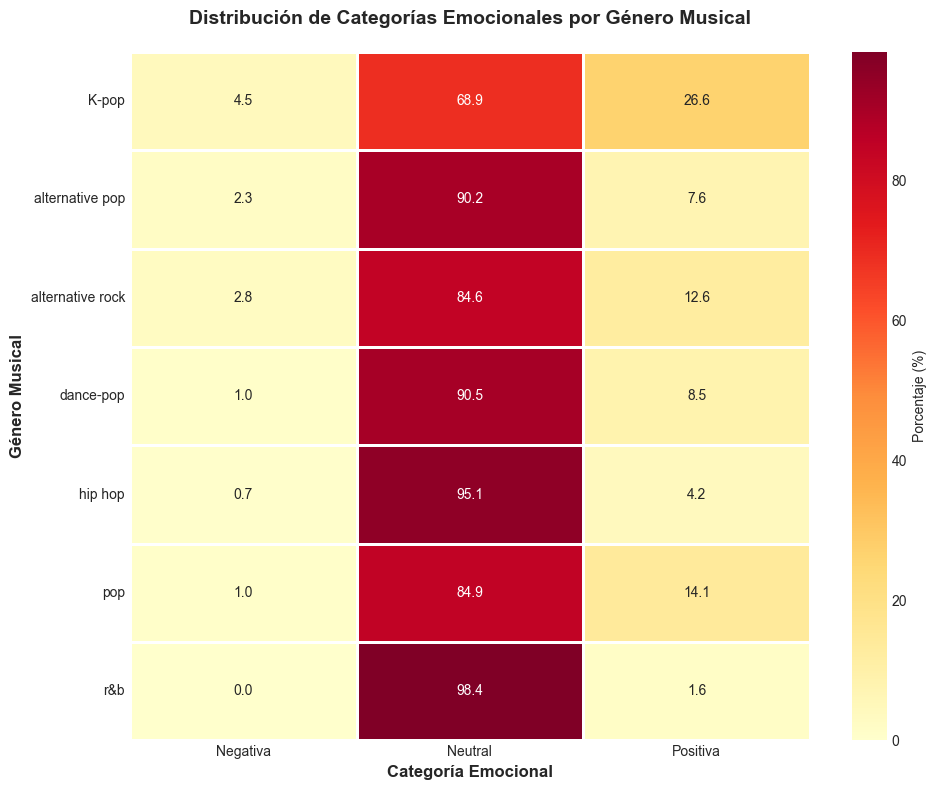


--------------------------------------------------------------------------------
MÉTRICAS MORFOSINTÁCTICAS POR GÉNERO Y CATEGORÍA EMOCIONAL
--------------------------------------------------------------------------------

pop:
  Positiva (416 canciones):
    Densidad Adjetivos: 9.61%
    Ratio V.Acción/Estado: 2.30
    Complejidad Sintáctica: 12.61%
  Neutral (2501 canciones):
    Densidad Adjetivos: 9.17%
    Ratio V.Acción/Estado: 2.71
    Complejidad Sintáctica: 12.51%
  Negativa (29 canciones):
    Densidad Adjetivos: 14.99%
    Ratio V.Acción/Estado: 2.88
    Complejidad Sintáctica: 17.26%

alternative pop:
  Positiva (10 canciones):
    Densidad Adjetivos: 7.75%
    Ratio V.Acción/Estado: 1.91
    Complejidad Sintáctica: 11.77%
  Neutral (119 canciones):
    Densidad Adjetivos: 9.45%
    Ratio V.Acción/Estado: 2.72
    Complejidad Sintáctica: 12.85%
  Negativa (3 canciones):
    Densidad Adjetivos: 20.90%
    Ratio V.Acción/Estado: 1.45
    Complejidad Sintáctica: 23.75%

K-pop:

In [10]:
# 7. Análisis por género musical y emoción

print("="*80)
print("ANÁLISIS POR GÉNERO MUSICAL Y EMOCIÓN")
print("="*80)

# Distribución de emociones por género
distribucion_emociones = pd.crosstab(
    df['Genero'],
    df['categoria_emocional'],
    normalize='index'
) * 100

print("\nDistribución de categorías emocionales por género (%):")
print(distribucion_emociones.round(2))

# Visualización: Heatmap de distribución emocional por género
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(distribucion_emociones,
            annot=True,
            fmt='.1f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Porcentaje (%)'},
            linewidths=1,
            ax=ax)

ax.set_xlabel('Categoría Emocional', fontsize=12, fontweight='bold')
ax.set_ylabel('Género Musical', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Categorías Emocionales por Género Musical',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Métricas morfosintácticas por género y emoción
print("\n" + "-"*80)
print("MÉTRICAS MORFOSINTÁCTICAS POR GÉNERO Y CATEGORÍA EMOCIONAL")
print("-"*80)

for genero in df['Genero'].unique()[:5]:  # Top 5 géneros
    print(f"\n{genero}:")
    df_genero = df[df['Genero'] == genero]

    for categoria in categorias:
        df_filtrado = df_genero[df_genero['categoria_emocional'] == categoria]

        if len(df_filtrado) > 0:
            print(f"  {categoria} ({len(df_filtrado)} canciones):")
            print(f"    Densidad Adjetivos: {df_filtrado['densidad_adjetivos'].mean():.2f}%")
            print(f"    Ratio V.Acción/Estado: {df_filtrado['ratio_verbos_accion_estado'].mean():.2f}")
            print(f"    Complejidad Sintáctica: {df_filtrado['complejidad_sintactica'].mean():.2f}%")

print("\n" + "="*80)

## Sección 8: Scatter plots - Relaciones bivariadas

VISUALIZACIÓN DE RELACIONES BIVARIADAS


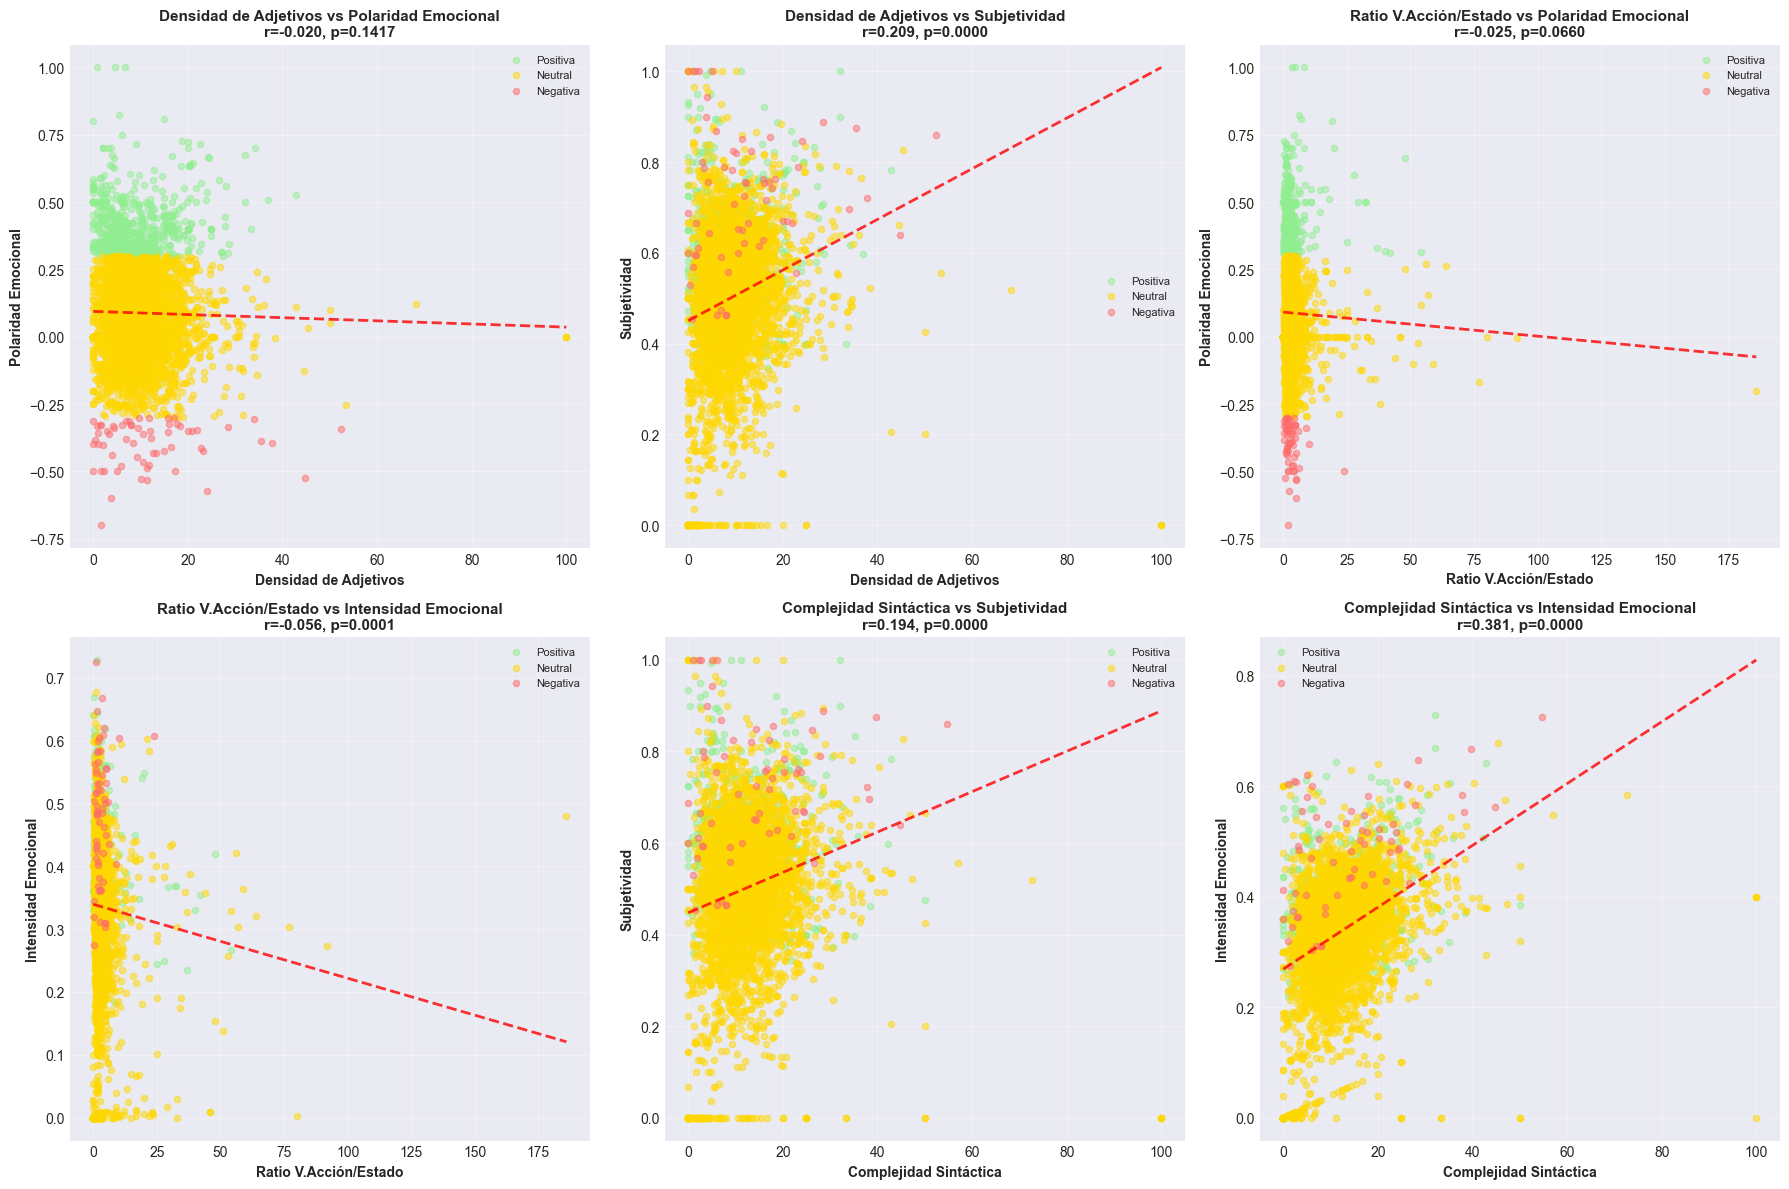

✓ Scatter plots creados


In [11]:
# 8. Scatter plots - Relaciones bivariadas

print("="*80)
print("VISUALIZACIÓN DE RELACIONES BIVARIADAS")
print("="*80)

# Crear scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

relaciones = [
    ('densidad_adjetivos', 'polaridad', 'Densidad de Adjetivos', 'Polaridad Emocional'),
    ('densidad_adjetivos', 'subjetividad', 'Densidad de Adjetivos', 'Subjetividad'),
    ('ratio_verbos_accion_estado', 'polaridad', 'Ratio V.Acción/Estado', 'Polaridad Emocional'),
    ('ratio_verbos_accion_estado', 'intensidad_emocional', 'Ratio V.Acción/Estado', 'Intensidad Emocional'),
    ('complejidad_sintactica', 'subjetividad', 'Complejidad Sintáctica', 'Subjetividad'),
    ('complejidad_sintactica', 'intensidad_emocional', 'Complejidad Sintáctica', 'Intensidad Emocional')
]

for idx, (var_x, var_y, label_x, label_y) in enumerate(relaciones):
    ax = axes[idx]

    # Datos
    df_plot = df[[var_x, var_y, 'categoria_emocional']].dropna()

    # Scatter por categoría emocional
    for categoria, color in zip(categorias, ['#90EE90', '#FFD700', '#FF6B6B']):
        df_cat = df_plot[df_plot['categoria_emocional'] == categoria]
        ax.scatter(df_cat[var_x], df_cat[var_y],
                  alpha=0.5, s=20, color=color, label=categoria)

    # Línea de tendencia general
    z = np.polyfit(df_plot[var_x], df_plot[var_y], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_plot[var_x].min(), df_plot[var_x].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

    # Calcular correlación
    corr, p_value = pearsonr(df_plot[var_x], df_plot[var_y])

    ax.set_xlabel(label_x, fontsize=10, fontweight='bold')
    ax.set_ylabel(label_y, fontsize=10, fontweight='bold')
    ax.set_title(f'{label_x} vs {label_y}\nr={corr:.3f}, p={p_value:.4f}',
                fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Scatter plots creados")

## Sección 9: Análisis de palabras emocionales con spaCy

ANÁLISIS DE PALABRAS EMOCIONALES
Contando palabras emocionales...
✓ Palabras emocionales contadas

Estadísticas de palabras emocionales:
       pct_palabras_positivas  pct_palabras_negativas
count             5208.000000             5208.000000
mean                 3.293571                2.114756
std                  4.842800                3.061904
min                  0.000000                0.000000
25%                  0.389105                0.000000
50%                  1.612903                1.140867
75%                  4.125841                2.741069
max                 50.000000               40.322581

--------------------------------------------------------------------------------
DENSIDAD DE PALABRAS EMOCIONALES POR CATEGORÍA
--------------------------------------------------------------------------------

Positiva:
  Palabras Positivas: 9.219%
  Palabras Negativas: 1.272%

Neutral:
  Palabras Positivas: 2.538%
  Palabras Negativas: 2.191%

Negativa:
  Palabras Positiva

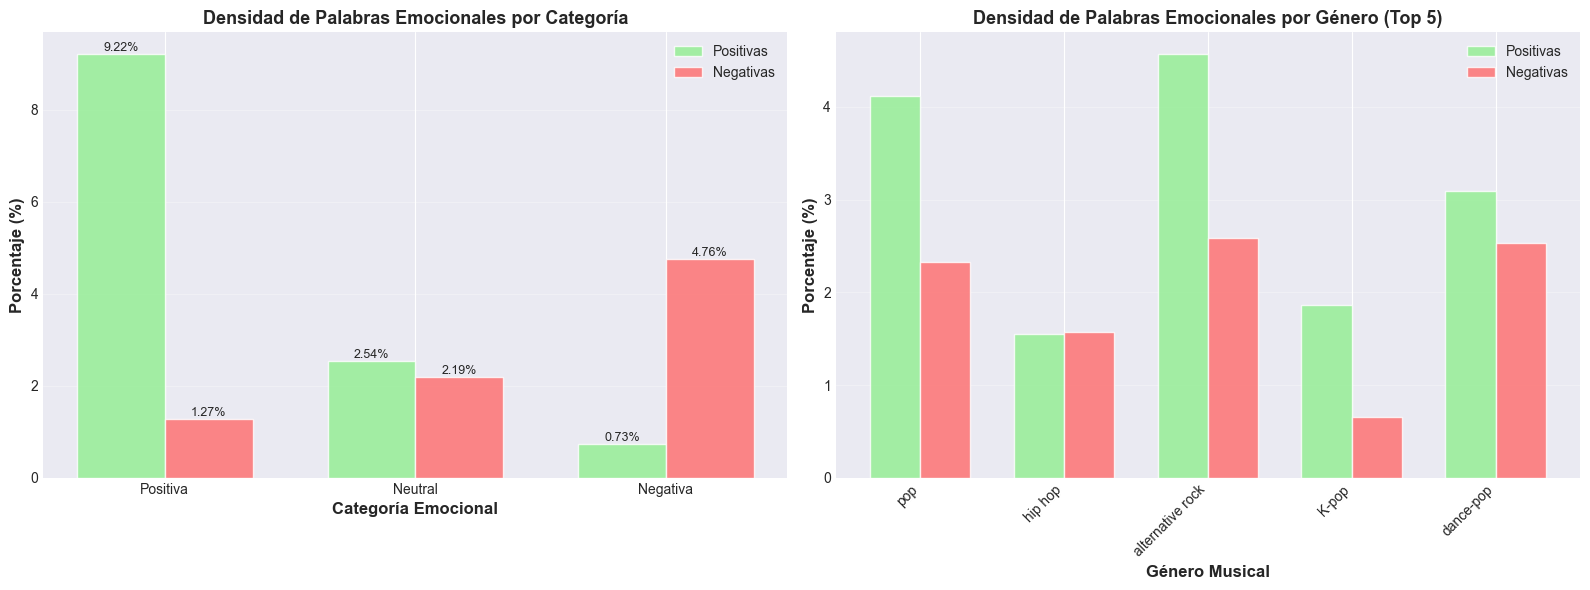

✓ Visualizaciones de palabras emocionales creadas


In [12]:
# 9. Análisis de palabras emocionales con spaCy

print("="*80)
print("ANÁLISIS DE PALABRAS EMOCIONALES")
print("="*80)

# Diccionarios de palabras emocionales
palabras_positivas = {
    'love', 'happy', 'joy', 'beautiful', 'good', 'amazing', 'wonderful',
    'great', 'perfect', 'smile', 'dream', 'hope', 'light', 'heaven',
    'sweet', 'forever', 'together', 'free', 'peace', 'bright'
}

palabras_negativas = {
    'hate', 'sad', 'pain', 'hurt', 'broken', 'cry', 'dark', 'lost',
    'alone', 'empty', 'fear', 'death', 'hell', 'wrong', 'bad',
    'never', 'die', 'goodbye', 'end', 'tear'
}

def contar_palabras_emocionales(texto, pos_list):
    """
    Cuenta palabras emocionales positivas y negativas.
    """
    if pd.isna(texto):
        return 0, 0

    doc = nlp(str(texto).lower())

    positivas = sum(1 for token in doc if token.lemma_ in palabras_positivas)
    negativas = sum(1 for token in doc if token.lemma_ in palabras_negativas)

    total_tokens = len(pos_list) if pos_list else 1

    return (positivas / total_tokens * 100), (negativas / total_tokens * 100)

print("Contando palabras emocionales...")

df[['pct_palabras_positivas', 'pct_palabras_negativas']] = df.apply(
    lambda row: pd.Series(contar_palabras_emocionales(row['letra_cancion'], row['pos_list'])),
    axis=1
)

print("✓ Palabras emocionales contadas")

# Estadísticas
print("\nEstadísticas de palabras emocionales:")
print(df[['pct_palabras_positivas', 'pct_palabras_negativas']].describe())

# Correlación con categoría emocional
print("\n" + "-"*80)
print("DENSIDAD DE PALABRAS EMOCIONALES POR CATEGORÍA")
print("-"*80)

for categoria in categorias:
    df_cat = df[df['categoria_emocional'] == categoria]
    print(f"\n{categoria}:")
    print(f"  Palabras Positivas: {df_cat['pct_palabras_positivas'].mean():.3f}%")
    print(f"  Palabras Negativas: {df_cat['pct_palabras_negativas'].mean():.3f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Por categoría emocional
ax1 = axes[0]
width = 0.35
x = np.arange(len(categorias))

positivas_means = [df[df['categoria_emocional']==cat]['pct_palabras_positivas'].mean()
                   for cat in categorias]
negativas_means = [df[df['categoria_emocional']==cat]['pct_palabras_negativas'].mean()
                   for cat in categorias]

bars1 = ax1.bar(x - width/2, positivas_means, width, label='Positivas', color='#90EE90', alpha=0.8)
bars2 = ax1.bar(x + width/2, negativas_means, width, label='Negativas', color='#FF6B6B', alpha=0.8)

ax1.set_xlabel('Categoría Emocional', fontsize=12, fontweight='bold')
ax1.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax1.set_title('Densidad de Palabras Emocionales por Categoría', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categorias)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Por género
ax2 = axes[1]
generos_top5 = df['Genero'].value_counts().head(5).index

positivas_genero = [df[df['Genero']==gen]['pct_palabras_positivas'].mean()
                    for gen in generos_top5]
negativas_genero = [df[df['Genero']==gen]['pct_palabras_negativas'].mean()
                    for gen in generos_top5]

x2 = np.arange(len(generos_top5))
bars3 = ax2.bar(x2 - width/2, positivas_genero, width, label='Positivas', color='#90EE90', alpha=0.8)
bars4 = ax2.bar(x2 + width/2, negativas_genero, width, label='Negativas', color='#FF6B6B', alpha=0.8)

ax2.set_xlabel('Género Musical', fontsize=12, fontweight='bold')
ax2.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax2.set_title('Densidad de Palabras Emocionales por Género (Top 5)', fontsize=13, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(generos_top5, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones de palabras emocionales creadas")

## Sección 10: Análisis de verbos de acción vs estado por emoción

ANÁLISIS DETALLADO: VERBOS DE ACCIÓN VS ESTADO

Ratio Verbos Acción/Estado por categoría emocional:
  Positiva: 2.998 ± 5.078
  Neutral: 2.911 ± 5.093
  Negativa: 3.111 ± 3.298

ANOVA - Ratio Verbos entre categorías emocionales:
  F-statistic: 0.1224
  p-value: 0.884757
  ✗ No hay diferencias significativas


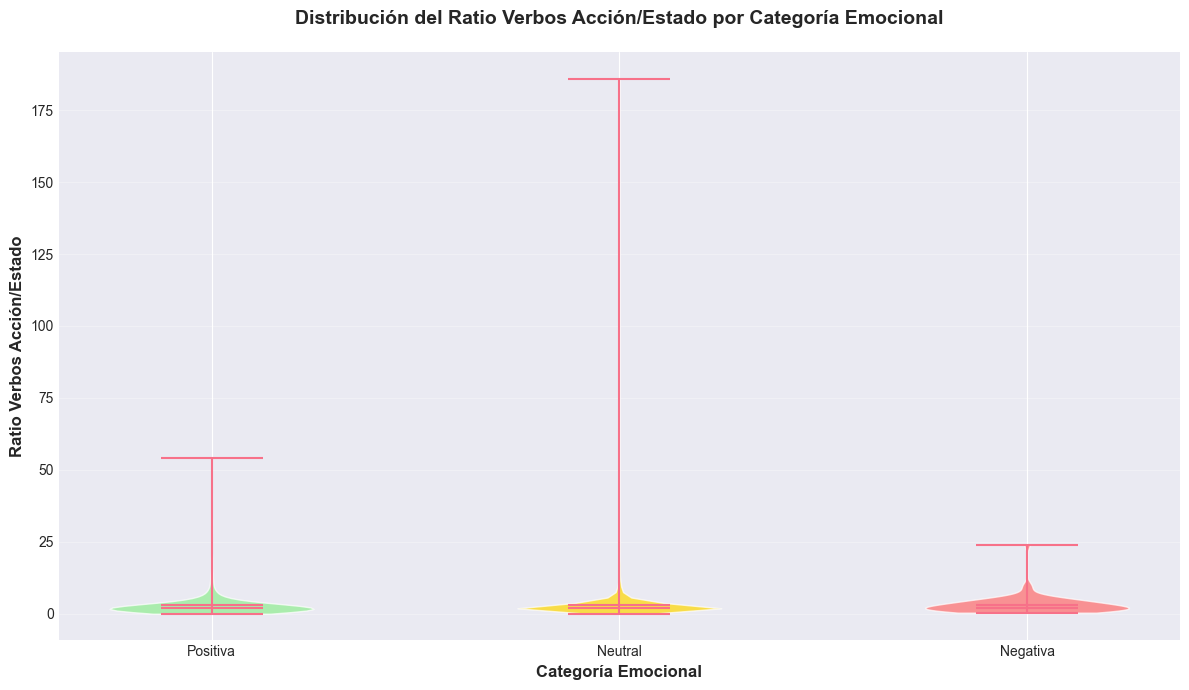

✓ Análisis de verbos completado


In [13]:
# 10. Análisis de verbos de acción vs estado por emoción

print("="*80)
print("ANÁLISIS DETALLADO: VERBOS DE ACCIÓN VS ESTADO")
print("="*80)

# Estadísticas por categoría emocional
print("\nRatio Verbos Acción/Estado por categoría emocional:")
for categoria in categorias:
    df_cat = df[df['categoria_emocional'] == categoria]
    ratio_mean = df_cat['ratio_verbos_accion_estado'].mean()
    ratio_std = df_cat['ratio_verbos_accion_estado'].std()

    print(f"  {categoria}: {ratio_mean:.3f} ± {ratio_std:.3f}")

# Test ANOVA
from scipy.stats import f_oneway

grupos = [df[df['categoria_emocional']==cat]['ratio_verbos_accion_estado'].dropna()
          for cat in categorias]

f_stat, p_value = f_oneway(*grupos)

print(f"\nANOVA - Ratio Verbos entre categorías emocionales:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'}")

# Visualización: Violin plot
fig, ax = plt.subplots(figsize=(12, 7))

datos_violin = [df[df['categoria_emocional']==cat]['ratio_verbos_accion_estado'].dropna()
                for cat in categorias]

parts = ax.violinplot(datos_violin,
                      positions=range(len(categorias)),
                      showmeans=True,
                      showmedians=True)

# Colorear violines
colors = ['#90EE90', '#FFD700', '#FF6B6B']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks(range(len(categorias)))
ax.set_xticklabels(categorias)
ax.set_xlabel('Categoría Emocional', fontsize=12, fontweight='bold')
ax.set_ylabel('Ratio Verbos Acción/Estado', fontsize=12, fontweight='bold')
ax.set_title('Distribución del Ratio Verbos Acción/Estado por Categoría Emocional',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Análisis de verbos completado")

## Sección 11: Perfiles emocionales por género

PERFILES EMOCIONALES POR GÉNERO MUSICAL

Perfiles emocionales por género (Top 5):
             Genero  N_Canciones  Polaridad_Media  Subjetividad_Media  \
0               pop         2946            0.114               0.499   
1           hip hop         1316            0.024               0.505   
2  alternative rock          285            0.096               0.491   
3             K-pop          267            0.156               0.507   
4         dance-pop          199            0.071               0.472   

   Intensidad_Media  Densidad_Adj_Media  Ratio_Verbos_Media  \
0             0.337               9.294               2.656   
1             0.339               8.985               2.571   
2             0.330               8.896               3.147   
3             0.321               4.164               7.531   
4             0.318               8.614               3.029   

   Complejidad_Media  Pct_Positivas  Pct_Negativas  Pct_Neutrales  
0             12.569         14.

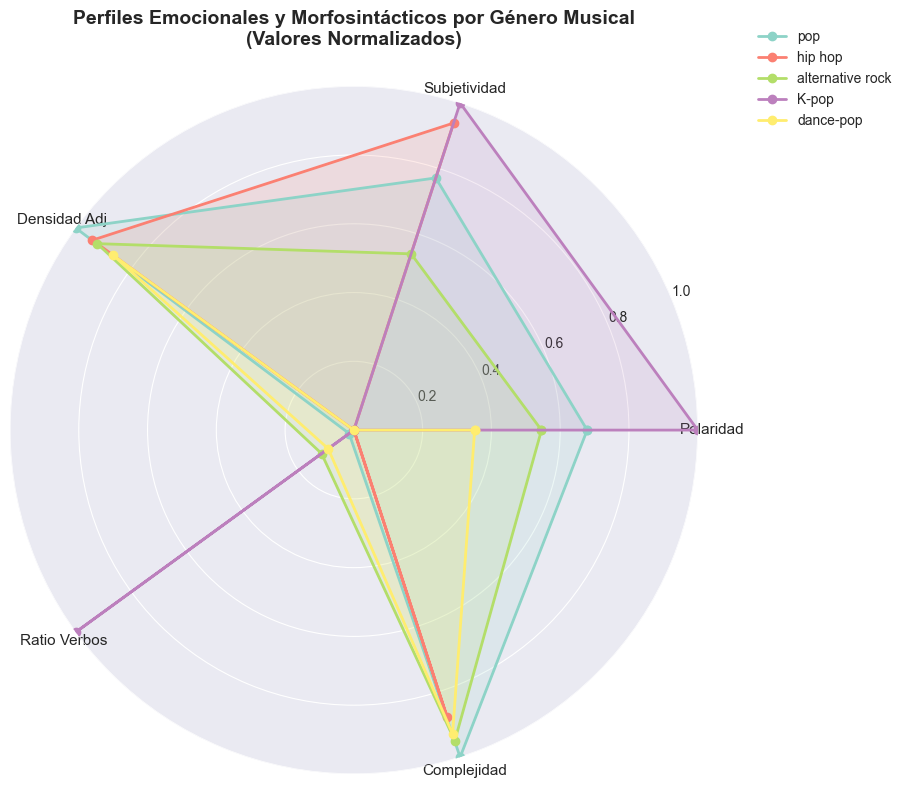

✓ Perfiles emocionales por género creados


In [14]:
# 11. Perfiles emocionales por género

print("="*80)
print("PERFILES EMOCIONALES POR GÉNERO MUSICAL")
print("="*80)

# Crear perfiles para cada género
generos_analisis = df['Genero'].value_counts().head(5).index

perfiles_genero = []

for genero in generos_analisis:
    df_genero = df[df['Genero'] == genero]

    perfil = {
        'Genero': genero,
        'N_Canciones': len(df_genero),
        'Polaridad_Media': df_genero['polaridad'].mean(),
        'Subjetividad_Media': df_genero['subjetividad'].mean(),
        'Intensidad_Media': df_genero['intensidad_emocional'].mean(),
        'Densidad_Adj_Media': df_genero['densidad_adjetivos'].mean(),
        'Ratio_Verbos_Media': df_genero['ratio_verbos_accion_estado'].mean(),
        'Complejidad_Media': df_genero['complejidad_sintactica'].mean(),
        'Pct_Positivas': (df_genero['categoria_emocional']=='Positiva').sum() / len(df_genero) * 100,
        'Pct_Negativas': (df_genero['categoria_emocional']=='Negativa').sum() / len(df_genero) * 100,
        'Pct_Neutrales': (df_genero['categoria_emocional']=='Neutral').sum() / len(df_genero) * 100
    }

    perfiles_genero.append(perfil)

df_perfiles = pd.DataFrame(perfiles_genero)

print("\nPerfiles emocionales por género (Top 5):")
print(df_perfiles.round(3))

# Visualización: Radar chart comparativo
from math import pi

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

# Seleccionar métricas para el radar
metricas_radar = ['Polaridad_Media', 'Subjetividad_Media', 'Densidad_Adj_Media',
                  'Ratio_Verbos_Media', 'Complejidad_Media']
etiquetas_radar = ['Polaridad', 'Subjetividad', 'Densidad Adj.',
                   'Ratio Verbos', 'Complejidad']

# Normalizar valores entre 0 y 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_perfiles_norm = df_perfiles.copy()
df_perfiles_norm[metricas_radar] = scaler.fit_transform(df_perfiles[metricas_radar])

# Ángulos para cada métrica
angulos = [n / len(metricas_radar) * 2 * pi for n in range(len(metricas_radar))]
angulos += angulos[:1]

# Plotear cada género
colores = plt.cm.Set3(np.linspace(0, 1, len(generos_analisis)))

for idx, genero in enumerate(generos_analisis):
    valores = df_perfiles_norm[df_perfiles_norm['Genero']==genero][metricas_radar].values.flatten().tolist()
    valores += valores[:1]

    ax.plot(angulos, valores, 'o-', linewidth=2, label=genero, color=colores[idx])
    ax.fill(angulos, valores, alpha=0.15, color=colores[idx])

ax.set_xticks(angulos[:-1])
ax.set_xticklabels(etiquetas_radar, size=11)
ax.set_ylim(0, 1)
ax.set_title('Perfiles Emocionales y Morfosintácticos por Género Musical\n(Valores Normalizados)',
             fontsize=14, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

print("✓ Perfiles emocionales por género creados")

## Sección 12: Pruebas estadísticas de significancia

In [15]:
# 12. Pruebas estadísticas de significancia

print("="*80)
print("PRUEBAS ESTADÍSTICAS DE SIGNIFICANCIA")
print("="*80)

# Test 1: ¿La densidad de adjetivos varía según la categoría emocional?
print("\n1. ANOVA - Densidad de Adjetivos por Categoría Emocional:")
grupos_adj = [df[df['categoria_emocional']==cat]['densidad_adjetivos'].dropna()
              for cat in categorias]
f_stat, p_value = f_oneway(*grupos_adj)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'}")

# Test 2: ¿La complejidad sintáctica varía según la categoría emocional?
print("\n2. ANOVA - Complejidad Sintáctica por Categoría Emocional:")
grupos_comp = [df[df['categoria_emocional']==cat]['complejidad_sintactica'].dropna()
               for cat in categorias]
f_stat, p_value = f_oneway(*grupos_comp)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'}")

# Test 3: Correlación entre densidad de adjetivos e intensidad emocional por género
print("\n3. Correlación Densidad Adjetivos ↔ Intensidad Emocional por Género:")
for genero in generos_analisis:
    df_genero = df[df['Genero']==genero][['densidad_adjetivos', 'intensidad_emocional']].dropna()

    if len(df_genero) > 3:
        corr, p_value = pearsonr(df_genero['densidad_adjetivos'],
                                 df_genero['intensidad_emocional'])
        significancia = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"   {genero}: r={corr:.4f}, p={p_value:.4f} {significancia}")

# Test 4: Chi-cuadrado - Independencia entre género y categoría emocional
print("\n4. Chi-Cuadrado - Género vs Categoría Emocional:")
tabla_contingencia = pd.crosstab(df['Genero'], df['categoria_emocional'])
chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)
print(f"   Chi-cuadrado: {chi2:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   Grados de libertad: {dof}")
print(f"   {'✓ Existe dependencia' if p_value < 0.05 else '✗ No hay dependencia'}")

print("\n" + "="*80)

PRUEBAS ESTADÍSTICAS DE SIGNIFICANCIA

1. ANOVA - Densidad de Adjetivos por Categoría Emocional:
   F-statistic: 9.0948
   p-value: 0.000114
   ✓ Diferencias significativas

2. ANOVA - Complejidad Sintáctica por Categoría Emocional:
   F-statistic: 3.7520
   p-value: 0.023533
   ✓ Diferencias significativas

3. Correlación Densidad Adjetivos ↔ Intensidad Emocional por Género:
   pop: r=0.4652, p=0.0000 ***
   hip hop: r=0.3023, p=0.0000 ***
   alternative rock: r=0.4704, p=0.0000 ***
   K-pop: r=0.2421, p=0.0001 ***
   dance-pop: r=0.4937, p=0.0000 ***

4. Chi-Cuadrado - Género vs Categoría Emocional:
   Chi-cuadrado: 198.2519
   p-value: 0.000000
   Grados de libertad: 12
   ✓ Existe dependencia



## Sección 13: Modelos predictivos simples

MODELOS PREDICTIVOS: MORFOSINTAXIS → EMOCIÓN

1. Modelo de Regresión Lineal - Predecir Polaridad:
   R² Score: 0.0019
   RMSE: 0.1780
   Coeficientes:
     densidad_adjetivos: -0.0020
     ratio_verbos_accion_estado: -0.0009
     complejidad_sintactica: 0.0013

2. Modelo de Regresión Lineal - Predecir Subjetividad:
   R² Score: 0.0447
   RMSE: 0.1618
   Coeficientes:
     densidad_adjetivos: 0.0044
     ratio_verbos_accion_estado: -0.0003
     complejidad_sintactica: 0.0011

3. Modelo de Regresión Lineal - Predecir Intensidad Emocional:
   R² Score: 0.1817
   RMSE: 0.0971
   Coeficientes:
     densidad_adjetivos: 0.0066
     ratio_verbos_accion_estado: -0.0002
     complejidad_sintactica: 0.0007


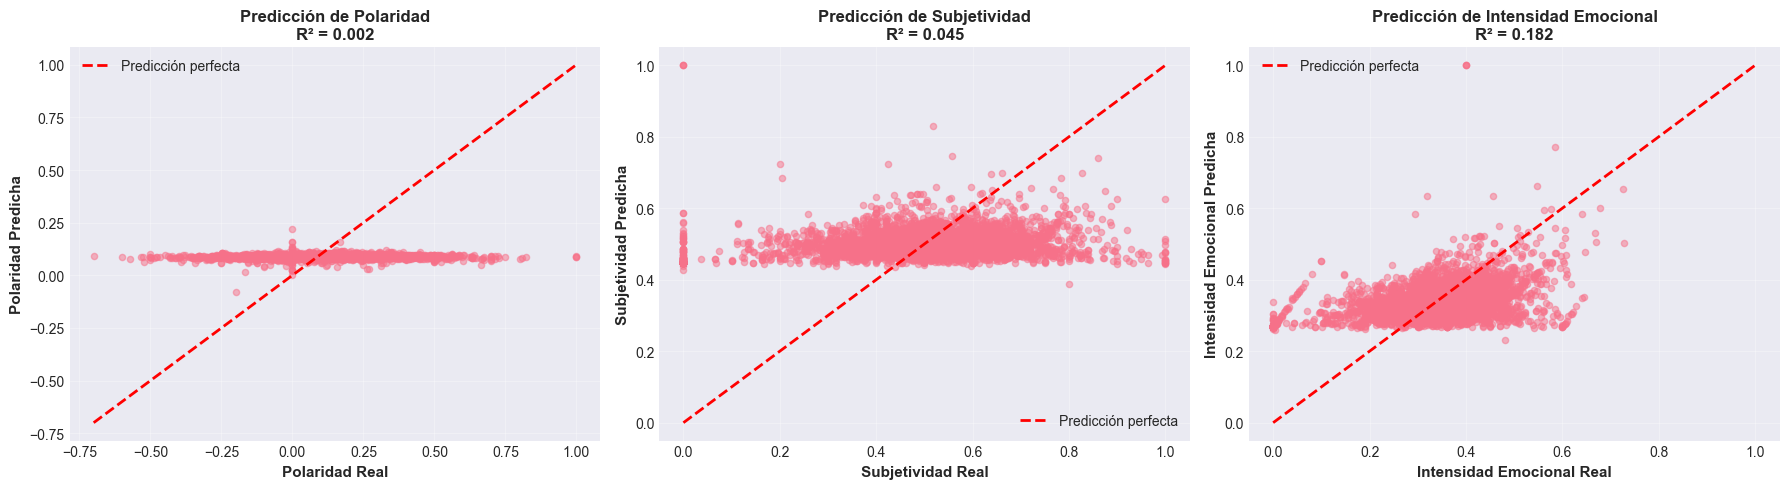


✓ Modelos predictivos completados


In [16]:
# 13. Modelos predictivos simples

print("="*80)
print("MODELOS PREDICTIVOS: MORFOSINTAXIS → EMOCIÓN")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Preparar datos
X = df[['densidad_adjetivos', 'ratio_verbos_accion_estado', 'complejidad_sintactica']].dropna()
y_polaridad = df.loc[X.index, 'polaridad']
y_subjetividad = df.loc[X.index, 'subjetividad']
y_intensidad = df.loc[X.index, 'intensidad_emocional']

# Modelo 1: Predecir Polaridad
print("\n1. Modelo de Regresión Lineal - Predecir Polaridad:")
modelo_polaridad = LinearRegression()
modelo_polaridad.fit(X, y_polaridad)
y_pred = modelo_polaridad.predict(X)

r2 = r2_score(y_polaridad, y_pred)
rmse = np.sqrt(mean_squared_error(y_polaridad, y_pred))

print(f"   R² Score: {r2:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   Coeficientes:")
for var, coef in zip(X.columns, modelo_polaridad.coef_):
    print(f"     {var}: {coef:.4f}")

# Modelo 2: Predecir Subjetividad
print("\n2. Modelo de Regresión Lineal - Predecir Subjetividad:")
modelo_subjetividad = LinearRegression()
modelo_subjetividad.fit(X, y_subjetividad)
y_pred = modelo_subjetividad.predict(X)

r2 = r2_score(y_subjetividad, y_pred)
rmse = np.sqrt(mean_squared_error(y_subjetividad, y_pred))

print(f"   R² Score: {r2:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   Coeficientes:")
for var, coef in zip(X.columns, modelo_subjetividad.coef_):
    print(f"     {var}: {coef:.4f}")

# Modelo 3: Predecir Intensidad Emocional
print("\n3. Modelo de Regresión Lineal - Predecir Intensidad Emocional:")
modelo_intensidad = LinearRegression()
modelo_intensidad.fit(X, y_intensidad)
y_pred = modelo_intensidad.predict(X)

r2 = r2_score(y_intensidad, y_pred)
rmse = np.sqrt(mean_squared_error(y_intensidad, y_pred))

print(f"   R² Score: {r2:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   Coeficientes:")
for var, coef in zip(X.columns, modelo_intensidad.coef_):
    print(f"     {var}: {coef:.4f}")

# Visualización de predicciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

modelos = [
    (modelo_polaridad, y_polaridad, 'Polaridad'),
    (modelo_subjetividad, y_subjetividad, 'Subjetividad'),
    (modelo_intensidad, y_intensidad, 'Intensidad Emocional')
]

for idx, (modelo, y_real, nombre) in enumerate(modelos):
    ax = axes[idx]

    y_pred = modelo.predict(X)
    r2 = r2_score(y_real, y_pred)

    ax.scatter(y_real, y_pred, alpha=0.5, s=20)

    # Línea de predicción perfecta
    min_val = min(y_real.min(), y_pred.min())
    max_val = max(y_real.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

    ax.set_xlabel(f'{nombre} Real', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'{nombre} Predicha', fontsize=11, fontweight='bold')
    ax.set_title(f'Predicción de {nombre}\nR² = {r2:.3f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Modelos predictivos completados")
print("="*80)

## Sección 14: Resumen ejecutivo de hallazgos

In [17]:
# 14. Resumen ejecutivo de hallazgos

print("="*80)
print("RESUMEN EJECUTIVO - EMOCIONALIDAD GRAMATICAL")
print("="*80)

resumen = """
HALLAZGOS PRINCIPALES:
======================

1. CORRELACIÓN MORFOSINTAXIS ↔ EMOCIÓN:
"""

print(resumen)

# Identificar correlaciones más fuertes
correlaciones_principales = []

for var_morfo in variables_morfosintacticas:
    for var_emoc in variables_emocionales:
        df_temp = df[[var_morfo, var_emoc]].dropna()
        corr, p_value = pearsonr(df_temp[var_morfo], df_temp[var_emoc])

        if abs(corr) > 0.1 and p_value < 0.05:
            correlaciones_principales.append({
                'morfosintaxis': var_morfo,
                'emocion': var_emoc,
                'correlacion': corr,
                'p_value': p_value
            })

# Ordenar por correlación absoluta
correlaciones_principales.sort(key=lambda x: abs(x['correlacion']), reverse=True)

print("   Correlaciones significativas (|r| > 0.1, p < 0.05):")
for item in correlaciones_principales[:5]:
    direccion = "positiva" if item['correlacion'] > 0 else "negativa"
    print(f"   • {item['morfosintaxis']} ↔ {item['emocion']}")
    print(f"     Correlación {direccion}: r={item['correlacion']:.3f}, p={item['p_value']:.4f}")

# Diferencias por categoría emocional
print("\n2. DIFERENCIAS POR CATEGORÍA EMOCIONAL:")
for categoria in categorias:
    df_cat = df[df['categoria_emocional'] == categoria]
    print(f"\n   {categoria} ({len(df_cat)} canciones):")
    print(f"   • Densidad de Adjetivos: {df_cat['densidad_adjetivos'].mean():.2f}%")
    print(f"   • Ratio Verbos A/E: {df_cat['ratio_verbos_accion_estado'].mean():.2f}")
    print(f"   • Complejidad Sintáctica: {df_cat['complejidad_sintactica'].mean():.2f}%")

# Géneros más emocionales
print("\n3. PERFILES EMOCIONALES POR GÉNERO:")
df_perfiles_sorted = df_perfiles.sort_values('Intensidad_Media', ascending=False)
print("\n   Géneros con mayor intensidad emocional:")
for idx, row in df_perfiles_sorted.head(3).iterrows():
    print(f"   {idx+1}. {row['Genero']}: {row['Intensidad_Media']:.3f}")
    print(f"      Polaridad: {row['Polaridad_Media']:.3f}, Subjetividad: {row['Subjetividad_Media']:.3f}")

# Capacidad predictiva
print("\n4. CAPACIDAD PREDICTIVA:")
print("   Las variables morfosintácticas pueden predecir:")
print(f"   • Polaridad: R² = {r2_score(y_polaridad, modelo_polaridad.predict(X)):.3f}")
print(f"   • Subjetividad: R² = {r2_score(y_subjetividad, modelo_subjetividad.predict(X)):.3f}")
print(f"   • Intensidad: R² = {r2_score(y_intensidad, modelo_intensidad.predict(X)):.3f}")

print("\n" + "="*80)

RESUMEN EJECUTIVO - EMOCIONALIDAD GRAMATICAL

HALLAZGOS PRINCIPALES:

1. CORRELACIÓN MORFOSINTAXIS ↔ EMOCIÓN:

   Correlaciones significativas (|r| > 0.1, p < 0.05):
   • densidad_adjetivos ↔ intensidad_emocional
     Correlación positiva: r=0.425, p=0.0000
   • complejidad_sintactica ↔ intensidad_emocional
     Correlación positiva: r=0.381, p=0.0000
   • densidad_adjetivos ↔ subjetividad
     Correlación positiva: r=0.209, p=0.0000
   • complejidad_sintactica ↔ subjetividad
     Correlación positiva: r=0.194, p=0.0000

2. DIFERENCIAS POR CATEGORÍA EMOCIONAL:

   Positiva (606 canciones):
   • Densidad de Adjetivos: 8.78%
   • Ratio Verbos A/E: 3.00
   • Complejidad Sintáctica: 11.68%

   Neutral (4539 canciones):
   • Densidad de Adjetivos: 8.91%
   • Ratio Verbos A/E: 2.91
   • Complejidad Sintáctica: 12.00%

   Negativa (63 canciones):
   • Densidad de Adjetivos: 12.23%
   • Ratio Verbos A/E: 3.11
   • Complejidad Sintáctica: 14.32%

3. PERFILES EMOCIONALES POR GÉNERO:

   Géneros 